# <span style="font-family:times; font-size:1.5em;"> <b>LipNet: Lip-reading Machine Learning Model

<span style="font-family:times; font-size:1.1em;">  Working in the LiveLipNet-env, for setting-up the environment and other python scripts, data and the saved checkpoints refer to - https://github.com/33ron33/Lip_reading

<span style="font-family:times; font-size:1.3em;"> Checking the installed libraries in the environment.

In [1]:
! pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiobotocore                   2.7.0
aiohttp                       3.9.0
aioitertools                  0.7.1
aiosignal                     1.2.0
alabaster                     0.7.12
altair                        5.3.0
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.4
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
apache-beam                   2.55.1
appdirs                       1.4.4
archspec                      0.2.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array_record                  0.5.1
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.3.4
asttokens                     2.0.5
astunparse                    1.6.3
async-lru

<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Importing the libraries used in the code.
</span>
</div>

In [1]:
import os # For opening and connnecting paths to the files
import cv2 # For computer Vision that is for image or video processing
import tensorflow as tf # For model training in Machine Learning
import numpy as np # For Numerical Operations
from matplotlib import pyplot as plt # For Plotting images (frames) and functions
import imageio # For converting the images to gifs
from typing import List

# Tensorflow Model Libraries.
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential # Represents the sequence of layers of the model.

# Components of the layered model architecture
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, Flatten 
from tensorflow.keras.optimizers import Adam # importing the optimizer for the model.

 # For saving the trained weights and for changing the lerning rate during training.  
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 

2024-04-25 23:47:14.924914: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 23:47:14.965545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Checking for the GPU availability.
</span>
</div>


In [2]:
# Checks for the GPU
!nvidia-smi
if len(tf.config.list_physical_devices('GPU'))>0:
    print( 'GPU is available!',tf.config.list_physical_devices('GPU'))
else:
    print("No GPU is available")

Thu Apr 25 23:47:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100S-PCIE-32GB          On  | 00000000:3B:00.0 Off |                    0 |
| N/A   40C    P0              26W / 250W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Defining our english letters and numbers that the model may encounter.
</span>
</div>

In [3]:
''' Loading the subtitles that are enocded in the .align files, but before that we need to describe our words and letters that the model may encounter-
and writing a code segment that can convert the numbers to the chararcters and the vice versa of it '''

vocab = "abcdefghijklmnopqrstuvwxyz'?!123456789 "
# Mapping the english letters to numbers
letter_to_number = tf.keras.layers.StringLookup(vocabulary=list(vocab), oov_token="")
 # Mapping the numbers to letters-
numbers_to_letters = tf.keras.layers.StringLookup(vocabulary=letter_to_number.get_vocabulary(), oov_token="", invert=True)

2024-04-25 23:47:41.241101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [4]:
print(f"The vocabulary is: {letter_to_number.get_vocabulary()} "f"(size ={letter_to_number.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [5]:
letter_to_number(['r','o','h','a','n'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([18, 15,  8,  1, 14])>

In [6]:
numbers_to_letters([18, 15,  8,  1, 14])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'r', b'o', b'h', b'a', b'n'], dtype=object)>

<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Importing and Pre-processing the GRID-dataset.
</span>
</div>

In [7]:
def grid_data_import(path: str): # -> Tuple[tf.Tensor, tf.Tensor]: This function imports the video and subtitle alignment data given the base path.
    

    def import_video(path: str) -> tf.Tensor:  # This function imports the video
        
        cap = cv2.VideoCapture(path) # Load the video
        frames = [] # Create an empty list to store the frames
        while True: # Loop through all the frames
            ret, frame = cap.read() # Read the frame
            if not ret: # If the frame is not read, break the loop
                break 
            frame = tf.image.rgb_to_grayscale(frame) # Convert the frame to grayscale
            frames.append(frame[190:236, 80:220, :]) # Crop the frame and append it to the list
        cap.release() # Release the video
        frames = tf.convert_to_tensor(frames, dtype=tf.float32) # Convert the list to a tensor
        mean = tf.math.reduce_mean(frames) # Calculate the mean of the frames so that we can normalize them
        std = tf.math.reduce_std(frames)    # Calculate the standard deviation of the frames
        return (frames - mean) / std # Normalize the frames and return them

    def import_subtitles(path: str) -> tf.Tensor:   # This function imports the subtitle alignment data
        """Import subtitle alignment data, convert them to indices using character to number conversion."""
        with open(path, 'r') as f: # Open the file
            lines = f.readlines() # Read the lines
        tokens = [] # Create an empty list to store the tokens
        for line in lines: # Loop through the lines
            parts = line.strip().split() # Split the line
            if parts[2] != 'sil':   # If the token is not a silence token
                tokens.extend([' ', parts[2]])  # Append the token to the list
        tokens = ''.join(tokens) # Join the tokens
        return letter_to_number(tf.strings.unicode_split(tokens, 'UTF-8')) # Convert the tokens to numbers

    
    # Check if input is a TensorFlow tensor and convert to Python string if so
    '''I have added this to make this complatible for both the calls for a string or a tensor'''
    if isinstance(path, tf.Tensor):
        path = path.numpy().decode('utf-8')
    else:
        path = path
        
    file_name = os.path.splitext(os.path.basename(path))[0] # Get the file name
    video_path = os.path.join('data', 's1', f'{file_name}.mpg') # Get the video path
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align') # Get the alignment path

    frames = import_video(video_path) # Import the video
    alignments = import_subtitles(alignment_path)    # Import the alignments 
    return frames, alignments


<div class='alert alert-success'> <span style="font-family:times; font-size:1.5em;"> Checking the functioning of the above defined grid_data_import function for a sample path.
</span>
</div>

<tf.Tensor: shape=(22,), dtype=int64, numpy=
array([39,  2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23,
       15, 39, 14, 15, 23])>

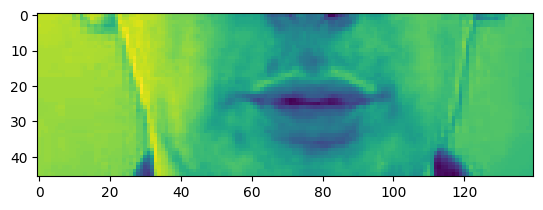

In [8]:
# Test the functionality
test_path = 'data/s1/bbaf2n.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

In [9]:
frames.shape

TensorShape([75, 46, 140, 1])

In [10]:
tf.strings.reduce_join([bytes.decode(x) for x in numbers_to_letters(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue at f two now'>

In [11]:
frames.shape

TensorShape([75, 46, 140, 1])

<span style="font-family:times; font-size:1.5em;"> Defining the functions seperately if need in the code.

In [58]:
def load_video(path: str) -> tf.Tensor:
    """Load video frames, convert them to grayscale, normalize them, and return as a tensor."""
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(frames)
    return (frames - mean) / std


In [59]:
def load_alignments(path: str) -> tf.Tensor:
    """Load alignment data, convert them to indices using character to number conversion."""
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        parts = line.strip().split()
        if parts[2] != 'sil':
            tokens.extend([' ', parts[2]])
    tokens = ''.join(tokens)
    return letter_to_number(tf.strings.unicode_split(tokens, 'UTF-8'))

In [60]:
def load_data(path: str):  # -> Tuple[List[float], List[str]]:
    path = bytes.decode(path.numpy()) # Convert the path to a string for 
    file_name = path.split('/')[-1].split('.')[0] # 
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg') 
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Creating a DATA Pipeline

In [15]:
'''Creating a dataset from the paths that is theis pipeline creates a path where the data is loaded in 
                                                                               from the s1 folder and the "data" function looks for a .mpg files'''
data = tf.data.Dataset.list_files('./data/s1/*.mpg') 
data.as_numpy_iterator().next()

b'./data/s1/srwo8p.mpg'

In [16]:
frames.shape

TensorShape([75, 46, 140, 1])

In [17]:
frames.shape

TensorShape([75, 46, 140, 1])

In [18]:
''' Shuffling the data to train the model with different sets., grabs the first 500 and then resuffles the data again'''
data = data.shuffle(500, reshuffle_each_iteration=False) 
data

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [19]:
frames.shape

TensorShape([75, 46, 140, 1])

In [20]:
'''Till now we are just getting the file path randomly, but we need the data, this is we define a mapping function'''
def mappable_function(path):    # -> Tuple[tf.Tensor, tf.Tensor]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64)) # Load the data
    return result 

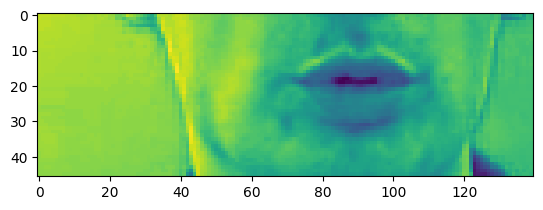

In [21]:
#  Map the data to the load_data function 
data = data.map(mappable_function) # Map the data to the load_data function 
# ---------  ------   Now look, we are able to get our data- frames and alignments  -------- ------ 
frames, alignments= data.as_numpy_iterator().next()
plt.imshow(frames[33])

In [22]:
frames.shape

(75, 46, 140, 1)

In [23]:
alignments 

array([39,  2,  9, 14, 39,  7, 18,  5,  5, 14, 39,  1, 20, 39, 21, 39, 15,
       14,  5, 39,  1,  7,  1,  9, 14])

In [24]:
'''We can see that the alignments are of different lenghts, so we also need to pad thedata set for alignments'''
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) # We will have two viodes and two alignents

In [25]:
data

<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [26]:
# Checking the shape of the dataset 
for frames, alignments in data.take(1):  # Take just one batch to examine
    print("Batched frames shape:", frames.shape)  # This will show the shape of frames in one batch
    print("Batched alignments shape:", alignments.shape)  # This will show the shape of alignments in one batch


Batched frames shape: (2, 75, 46, 140, 1)
Batched alignments shape: (2, 40)


In [27]:
data = data.prefetch(tf.data.AUTOTUNE)  

In [28]:
alignments.shape

TensorShape([2, 40])

In [29]:
len(frames)

2

In [30]:
test=data.as_numpy_iterator()

In [31]:
# val[0] -> Frames 
val=test.next();val[0]

array([[[[[ 1.2798681 ],
          [ 1.2798681 ],
          [ 1.2798681 ],
          ...,
          [-0.45000294],
          [-0.37137243],
          [-0.6858945 ]],

         [[ 1.2798681 ],
          [ 1.2798681 ],
          [ 1.2798681 ],
          ...,
          [-1.236308  ],
          [-0.8038402 ],
          [-0.6465792 ]],

         [[ 1.2798681 ],
          [ 1.2798681 ],
          [ 1.2798681 ],
          ...,
          [-0.5286335 ],
          [-0.29274192],
          [-0.25342667]],

         ...,

         [[ 0.88671565],
          [ 0.88671565],
          [ 0.88671565],
          ...,
          [-0.21411143],
          [-0.21411143],
          [-0.17479618]],

         [[ 0.88671565],
          [ 0.88671565],
          [ 0.88671565],
          ...,
          [-0.21411143],
          [-0.25342667],
          [-0.25342667]],

         [[ 0.88671565],
          [ 0.88671565],
          [ 0.88671565],
          ...,
          [-0.21411143],
          [-0.25342667],
          

In [32]:
for frames, alignments in data.take(1):  # Take just one batch to examine
    print("Batched frames shape:", frames.shape)  # Should show (2, 75, 46, 140, 1) for your batch

    # Select the first video in the batch
    first_video_frames = frames.numpy()[0]  # This will have shape (75, 46, 140, 1)
    print("First video frames shape:", first_video_frames.shape)

    # Convert frames from float32 to uint8, ensuring data is in the range 0-255
    frames_uint8 = np.clip(first_video_frames * 255, 0, 255).astype(np.uint8)

    # Reshape if necessary, check channels
    if frames_uint8.shape[-1] == 1:
        # Convert grayscale to RGB by repeating the channels
        frames_uint8 = np.repeat(frames_uint8, 3, axis=-1)

    # Save as GIF
    imageio.mimsave('./lip_movement.gif', frames_uint8, fps=10)


Batched frames shape: (2, 75, 46, 140, 1)
First video frames shape: (75, 46, 140, 1)


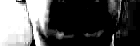

In [33]:
from IPython.display import Image
# Display the GIF in the notebook
Image(filename='./lip_movement.gif', width=400, height=300) 


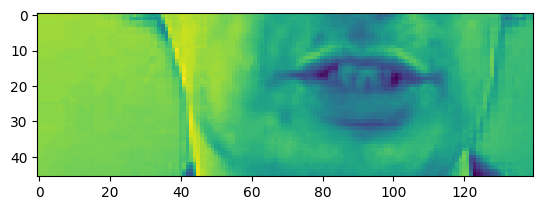

In [34]:
''' 1st [0] - videos
    2nd [0] - 1st video of the batch
    3rd [0]  - Number of the frame in the video
'''
plt.imshow(val[0][0][33])

# This command is plotting the 1st video of the batch and with the frame 33rd

In [35]:
frames.shape

TensorShape([2, 75, 46, 140, 1])

In [36]:
sample = data.as_numpy_iterator()

In [37]:
len(frames)

2

In [38]:
# Now we can see taht the padding is successful!

alignments

<tf.Tensor: shape=(2, 40), dtype=int64, numpy=
array([[39, 12,  1, 25, 39,  7, 18,  5,  5, 14, 39,  1, 20, 39, 13, 39,
        26,  5, 18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [39, 16, 12,  1,  3,  5, 39, 18,  5,  4, 39,  9, 14, 39, 16, 39,
        20,  8, 18,  5,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])>

In [39]:
# Meaning of thses alignments can be intrepreted by the tf.strings.reduce_join-
tf.strings.reduce_join([numbers_to_letters(x) for x in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue in r seven soon'>

<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Creating the Model Architecture.
</span>
</div>

<span style="font-family:times; font-size:1.5em;"> <span style='color:red'>For videos processing we are using the Conv3D and for training the model I have used the Loss function- CTC: https://keras.io/examples/audio/ctc_asr/
</span>

In [40]:
'''Batching the data that is - Splitting the data into training and testing'''
train = data.take(450)  # Trainiig data set
test = data.skip(450)  # Testing dataset

In [41]:
'''
   ---------------------------------------------------------------------- Model Architecture--------------------------------------------------------------------
'''
# Create the Sequential model
model = models.Sequential([
    
    # 3D Convolution Layer 1: This layer applies 128 filters of size (3, 3, 3) to the input data,
    layers.Conv3D(128, (3, 3, 3), padding='same', input_shape=(75, 46, 140, 1)),
    layers.Activation('relu'), # Introducing non-linearity to the model
    layers.MaxPool3D(pool_size=(1, 2, 2)),

    # 3D Convolution Layer 2: This layer applies 256 filters of size (3, 3, 3) to the input data,
    layers.Conv3D(256, (3, 3, 3), padding='same'),
    layers.Activation('relu'),
    layers.MaxPool3D(pool_size=(1, 2, 2)),

    # 3D Convolution Layer 3 : This layer applies 75 filters of size (3, 3, 3) to the input data,
    layers.Conv3D(75, (3, 3, 3), padding='same'),
    layers.Activation('relu'),
    layers.MaxPool3D(pool_size=(1, 2, 2)),

    # Flatten the output and prepare for LSTM Here from above we get the output as - (None, 75, 5, 17, 75) , then for flattening, we have preseerved the time frames and condednsed the rest to 
    #(None, 75, 5*17*75 = 6375)
    layers.TimeDistributed(Flatten()), 

    # Bidirectional LSTM Layer 1 : Bidirectional LSTM processes the sequence both forwards and backwards that is - two times (128 units) bi-directional
    layers.Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)),
    layers.Dropout(0.5),

    # Bidirectional LSTM Layer 2 : Bidirectional LSTM processes the sequence both forwards and backwards that is - two times (128 units) bi-directional
    layers.Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)),
    layers.Dropout(0.5),

    # Dense output layer gives out 75 frames and 41 characters 
    layers.Dense(letter_to_number.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax') 
])

# Summary of the model architechure
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

<div class='alert alert-warning'><span style='color:red'><span style="font-family:times; font-size:1.5em;"> <b>Making a check if the model is working or not before training it!
</b>
</span>
</span>
</div>

In [42]:
predictions = model.predict(val[0])

2024-04-25 23:48:00.027240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-04-25 23:48:00.113985: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step


In [43]:
# THus the model is predict this transcript for the video in terms of the alingments
tf.argmax(predictions[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5, 37, 37, 37, 37, 37, 37, 37, 37,
       37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
       37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
       37, 26, 26, 26, 26, 26, 26])>

In [44]:
# For actual representationss fo the letters we use - number_to_letters
# Get the argmax (index of the highest probability prediction) along the last dimension (character class probabilities)
predicted_indices = tf.argmax(predictions, axis=-1)

# Convert numerical indices to character strings
decoded_characters = numbers_to_letters(predicted_indices)

# Since `decoded_characters` will be a tensor of strings, use `tf.strings.reduce_join` to concatenate the strings along the sequence
decoded_strings = tf.strings.reduce_join(decoded_characters, axis=-1)

# Print the decoded strings
print(decoded_strings.numpy())

[b'eeeeeeeeeeeeeeeeeeeeeeeeee8888888888888888888888888888888888888888888zzzzzz'
 b'    6666666666666666666666666666bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb6666bbbbb']


In [45]:
class Example(tf.keras.callbacks.Callback):
    def __init__(self,dataset)->None:
        self.dataset=dataset.as_numpy_iterator()

    def on_epoch_end(self,epoch,logs=None)->None:
        data=self.dataset.next()
        predictions=self.model.predict(data[0])
        decoded=tf.keras.backend.ctc_decode(predictions,[75,75],greedy=False)[0][0].numpy()
        for x in range(len(predictions)):
            print('Actual Words:',tf.strings.reduce_join([vocab[word]+ '' for word in data[1][x]]).decode('utf-8'))
            print('Predicted Words:', tf.strings.reduce_join(numbers_to_letters(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [79]:
class Example(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()  # Initialize the base class
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None):
        try:
            data = self.dataset.next()
            predictions = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
            for x in range(len(predictions)):
                try:
                    actual_words = ' '.join([vocab.get(word, '?') for word in data[1][x]])  # Use get to avoid KeyError
                    predicted_words = ' '.join([numbers_to_letters[num].numpy().decode('utf-8') for num in decoded[x]])
                    print('Actual Words:', actual_words)
                    print('Predicted Words:', predicted_words)
                    print('~' * 100)
                except Exception as e:
                    print("Error processing text for batch index", x, ":", str(e))
        except Exception as e:
            print("Failed to process batch:", str(e))


<div class='alert alert-danger'><span style="font-family:times; font-size:1.5em;"> <b> Training the Model-
</b>
</span>
</div>

In [46]:
'''Thsi loss function is directly copied from the CTCLoss defiend for the Automatic Speech Recognition using CTC by 
   Authors: Mohamed Reda Bouadjenek and Ngoc Dung Huynh
   ---------------------------------------------------- https://keras.io/examples/audio/ctc_asr/ -----------------------------------------------------''' 
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

    return loss

<span style="font-family:times; font-size:1.5em;">Also for controlled training, lets define the model's learning rate scheduler which decreases the $\eta$ when epochs are very large!!!
 </span>

In [47]:
def L_rate_sch(epoch,lrs):
    if epoch < 33:
        return lrs
    else:
        return lrs*tf.math.exp(-0.1)

In [48]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss)

In [66]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Ensure the checkpoint directory exists
checkpoint_dir = 'Saved_LipNet_model/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Set up the ModelCheckpoint callback to save weights only
checkpoint_callback = ModelCheckpoint(
    os.path.join(checkpoint_dir, 'checkpoint'),  # Saves checkpoints to the directory
    monitor='loss',
    save_weights_only=True,
    save_best_only=True,  # Saves only the best model according to monitored 'loss'
    verbose=1  # Adds verbosity to output which can be helpful for debugging
)

In [80]:
schedule_callback=LearningRateScheduler(L_rate_sch)
_callback = Example(test)

In [108]:
training = {}  # 0.286
training = model.fit(train, validation_data=test,epochs=1,callbacks=[checkpoint_callback, schedule_callback],verbose=1)

450/450 [==============================] - ETA: 0s - loss: 2.7218

[mpeg1video @ 0x7ef15c078140] ac-tex damaged at 22 17
[mpeg1video @ 0x7ef15c078140] Warning MVs not available



Epoch 1: loss improved from 2.76912 to 2.72180, saving model to Saved_LipNet_model/checkpoints/checkpoint
450/450 [==============================] - 334s 741ms/step - loss: 2.7218 - val_loss: 2.9353 - lr: 1.0000e-04


In [100]:
# Define the path where the checkpoints are stored
checkpoint_dir = 'Saved_LipNet_model/checkpoints'
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [109]:
# Specify paths
video_path = 'data/s1/lbby2n.mpg'
alignment_path = 'data/alignments/s1/lbby2n.align'

# Load and preprocess the video and alignments
frames = load_video(video_path)
alignments = load_alignments(alignment_path)

# Ensure frames have a batch dimension
if len(frames.shape) == 4:
    frames = tf.expand_dims(frames, axis=0)

# Make predictions
predictions = model.predict(frames)

# Decode predictions
decoded_predictions = tf.keras.backend.ctc_decode(predictions, input_length=[frames.shape[1]] * frames.shape[0], greedy=True)[0][0]

# Convert predictions and actual indices to text
predicted_text = tf.strings.reduce_join(numbers_to_letters(decoded_predictions), separator='').numpy().decode('utf-8')
actual_text = tf.strings.reduce_join(numbers_to_letters(alignments), separator='').numpy().decode('utf-8')

# Display results
print('Actual Text:', actual_text)
print('Predicted Text:', predicted_text)

1/1 [==============================] - 0s 47ms/step
Actual Text:  lay blue by y two now
Predicted Text:  lay blue by y two now


In [111]:
#_______________________________________________________________________TEST_PERFORMED_ON_CUSTOM_DATASET_______________________________________________________

# Specify paths
video_path = 'data/test/lrwvzn.mpg'
alignment_path = 'data/test/lrwvzn.align'

# Load and preprocess the video and alignments
frames = load_video(video_path)
alignments = load_alignments(alignment_path)

# Ensure frames have a batch dimension
if len(frames.shape) == 4:
    frames = tf.expand_dims(frames, axis=0)

# Make predictions
predictions = model.predict(frames)

# Decode predictions
decoded_predictions = tf.keras.backend.ctc_decode(predictions, input_length=[frames.shape[1]] * frames.shape[0], greedy=True)[0][0]

# Convert predictions and actual indices to text
predicted_text = tf.strings.reduce_join(numbers_to_letters(decoded_predictions), separator='').numpy().decode('utf-8')
actual_text = tf.strings.reduce_join(numbers_to_letters(alignments), separator='').numpy().decode('utf-8')

# Display results
print('Actual Text:', actual_text)
print('Predicted Text:', predicted_text)

1/1 [==============================] - 0s 54ms/step
Actual Text:  lay red with v zero now
Predicted Text:  bny bie in y sive again
